In [38]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
from matplotlib.pyplot import cm

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


<b>The purpose of this notebook is to decompose NeverWorld2 flows into barotropic (BT) and baroclinic components (BC) and compute the kinetic energy (KE) associated with each. This will be done in two approaches. The first approach uses thickness-weighted (TW) averaging to compute TW BT and BC velocities and associated KE. The second approach uses a function provided by Jake Steinberg to compute QG modes for a given density and layer thickness profile. The flow is represented in terms of a sum of the QG modes of various amplitudes (amplitudes are solved for using a least-squares linear fit). The amplitudes are used to compute the KE of the barotropic mode (zeroeth mode) and baroclinic modes (all higher modes).<b>

In [39]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld2 setup
#run=26 #1/8 degree NeverWorld2 setup
#run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(av)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [7]:
# For the 1/32 degree run:

# %cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
# run=33 #1/32 degree NeverWorld setup
# fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
#os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
# forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)

# av=xr.open_mfdataset(['run33/averages_00001702.nc','run33/averages_00001802.nc', 'run33/averages_00001902.nc', 'run33/averages_00002002.nc', 'run33/averages_00002102.nc'],decode_times=False,combine='by_coords')
# print(av)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

<b>First following the thickness-weighted approach:</b>

In [42]:
#Read in grid variables:
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh = fs.xh.values
yh = fs.yh.values

#Outputs are comprised of 20 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]) 
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]) 
h  = np.array(av['h'][:,:,:,:]);
Depth_4D=np.transpose(np.tile(np.nansum(h,axis=1),[Nlayers,1,1,1]),(1,0,2,3))

#Compute thickness-weighted velocities at each layer
TW_u = u*h/Depth_4D; TW_v = v*h/Depth_4D;
#Computing barotropic velocities, as depth-mean, thickness-weighted velocities
BT_u = np.transpose(np.tile(np.nanmean(TW_u,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
BT_v = np.transpose(np.tile(np.nanmean(TW_v,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
# #Baroclinic velocities as difference between thickness weighted raw and BT velocities:
BC_u = TW_u-BT_u; BC_v = TW_v-BT_v;

print('done')

done


In [9]:
#Total kinetic energy based on thickness-weighted velocity:
KE_tot = 0.5*(TW_u)**2 + 0.5*(TW_v)**2;
#Barotropic kinetic energy:
KE_BT_u = 0.5*(BT_u)**2; KE_BT_v = 0.5*(BT_v)**2; 
KE_BT_tot = KE_BT_u+KE_BT_v;

#METHOD 1 for baroclinic KE: 
KE_BC_tot_1 = KE_tot-KE_BT_tot;
#METHOD 2 for baroclinic KE:
KE_BC_tot_2 = 0.5*(BC_u)**2+0.5*(BC_v)**2

print(KE_tot.shape)
print(KE_BT_tot.shape)
print(KE_BC_tot_1.shape)
print(KE_BC_tot_2.shape)

(100, 15, 560, 240)
(100, 15, 560, 240)
(100, 15, 560, 240)
(100, 15, 560, 240)


In [10]:
# print(KE_tot[10,10,100,100])
# print(KE_BT_tot[10,10,100,100]+KE_BC_tot_2[10,10,100,100])
#print(np.nanmean(KE_tot[:,10,100,100],axis=0))
#print((np.nanmean(KE_BT_tot[:,10,100,100]+KE_BC_tot_2[:,10,100,100],axis=0)))
#print(np.nansum(KE_tot[10,:,100,100],axis=0))
#print((np.nansum(KE_BT_tot[10,:,100,100]+KE_BC_tot_2[10,:,100,100],axis=0)))

#Showing that the vertical sum of two BC KE methods is the same
print(np.nansum(KE_BC_tot_1[50,:,150,190],axis=0)) #dimensions time, z, lat, lon.
print(np.nansum(KE_BC_tot_2[50,:,150,190],axis=0))

8.780414e-06
8.780415e-06


In [12]:
#Summing quantities to be plotted in depth, then averaging in time (order doesn't matter)
KE_tot_planview=np.nanmean(np.nansum(KE_tot,axis=1),axis=0) 
KE_BT_tot_planview=np.nanmean(np.nansum(KE_BT_tot,axis=1),axis=0) 
KE_BC_tot_1_planview=np.nanmean(np.nansum(KE_BC_tot_1,axis=1),axis=0) 
KE_BC_tot_2_planview=np.nanmean(np.nansum(KE_BC_tot_2,axis=1),axis=0) 

Text(0.5, 1.0, '$log_{10}(KE)$')

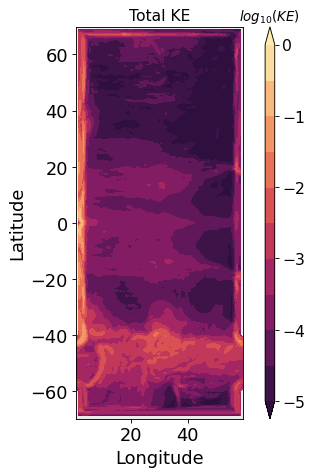

In [13]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Total KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_tot_planview),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')


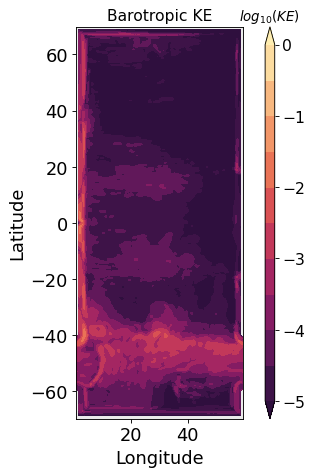

In [14]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Barotropic KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_BT_tot_planview),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

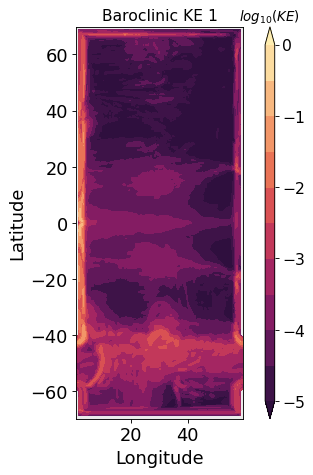

In [15]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Baroclinic KE 1',fontsize=14) #METHOD 1
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_BC_tot_1_planview),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

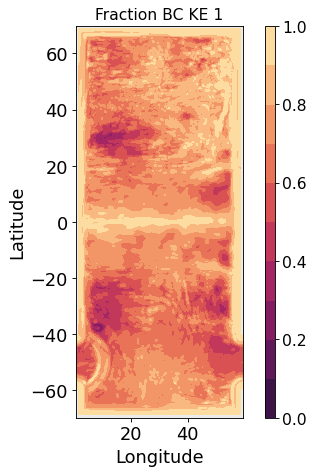

In [16]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Fraction BC KE 1',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

fraction_BC=KE_BC_tot_1_planview/KE_tot_planview
plotted =ax1.contourf(xh,yh,fraction_BC,levels=np.linspace(0.,1.,11),cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()

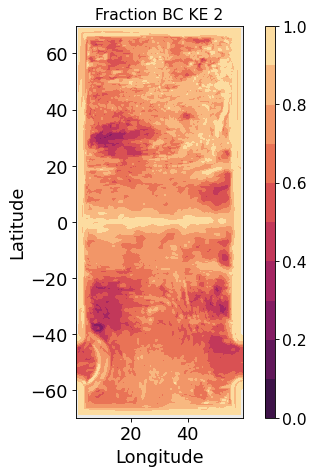

In [17]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Fraction BC KE 2',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

fraction_BC=KE_BC_tot_2_planview/KE_tot_planview
plotted =ax1.contourf(xh,yh,fraction_BC,levels=np.linspace(0.,1.,11),cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()

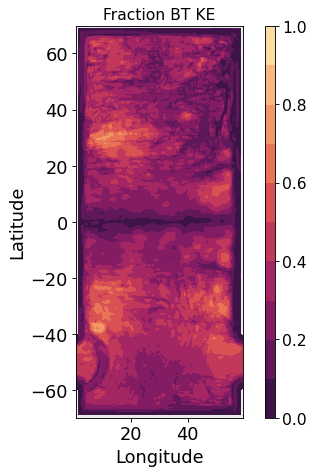

In [18]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Fraction BT KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

fraction_BT=KE_BT_tot_planview/KE_tot_planview
plotted =ax1.contourf(xh,yh,fraction_BT,levels=np.linspace(0.,1.,11),cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()

Text(0.5, 1.0, '1/4$^\\circ$ KE fractions')

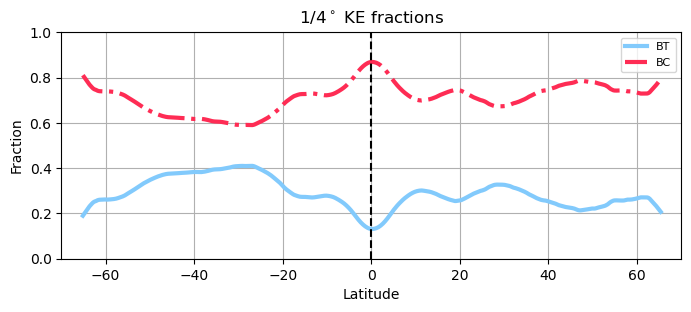

In [19]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(8, 3), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh,np.convolve(np.nanmean(fraction_BT,axis=1), np.ones((window,))/window, mode='same'),'-',c='#82cafc',linewidth=3)
plt.grid()
plt.plot(yh,np.convolve(np.nanmean(fraction_BC,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#fe2c54',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-70, 70)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fractions')

In [20]:
test = fraction_BC+fraction_BT;
print(np.nanmin(test),np.nanmax(test)) #min and max should be 1!

0.99999905 1.000001


<b>Next using the QG modal decomposition approach. The 'vertical_modes' function in the next cell was provided by Jake Steinberg.</b>

In [40]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 
#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))
    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon
#Gz is the vertical velocity structure (normalized)

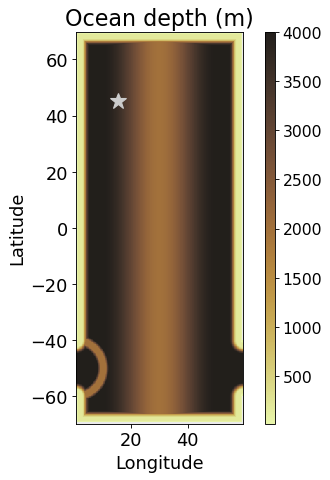

In [43]:
#1/4 degree:60 lat x 240 lon (double index values for each higher resolution)
#Location where the decomposition is performed:
index_lon=60; index_lat=460
xh = fs.xh.values
yh = fs.yh.values

#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=15,color=[0.8, 0.8, 0.8])
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

In [44]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)

#Using the last 5-day average:
v = (np.array(av['v'][-1,:,:,:])); v=(v[:,:-1,:]+v[:,1:,:])/2; v=v[:,index_lat,index_lon]
u = (np.array(av['u'][-1,:,:,:])); u=(u[:,:,:-1]+u[:,:,1:])/2; u=u[:,index_lat,index_lon]
h = np.array(av['h'][-1,:,index_lat,index_lon]);
eta = np.zeros(len(Layer)+1);

for i in range(1,len(Layer)+1):
    eta[i]=np.nansum(h[0:i])        
eta=(eta[1:]+eta[:-1])/2.
drhodz=drho/h
N2=(9.81/1025.)*drhodz


N2[N2>1.e-3] =np.nan
eta_filtered = eta[~np.isnan(N2)]
u_filtered = u[~np.isnan(N2)]
v_filtered = v[~np.isnan(N2)]
N2_filtered = N2[~np.isnan(N2)]

print(u_filtered.shape,N2_filtered.shape)

(12,) (12,)


In [45]:
nmodes=9
[G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Depth')

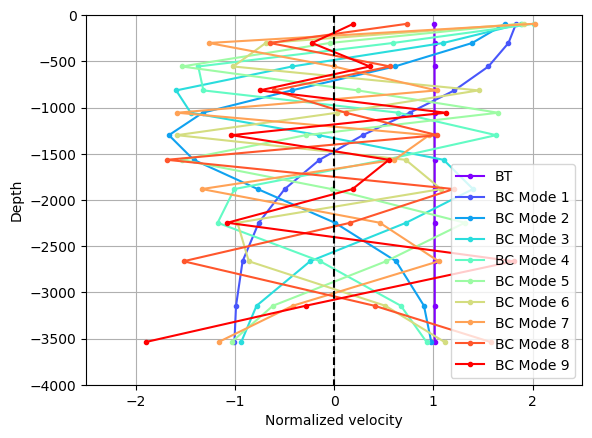

In [46]:
color=iter(cm.rainbow(np.linspace(0,1,nmodes+1))) #rainbow
plt.style.use('default')
for i in range(nmodes+1):
    print(i)
    c=next(color)
    plt.plot(Gz[:,i],-eta_filtered,'.-',c=c)
plt.grid()
plt.legend(['BT','BC Mode 1','BC Mode 2','BC Mode 3','BC Mode 4','BC Mode 5','BC Mode 6','BC Mode 7','BC Mode 8','BC Mode 9','BC Mode 10','BC Mode 11'])
plt.plot([0, 0],[0, -4000],'--',color=[0,0,0])
plt.xlim(-2.5, 2.5)
plt.ylim(-4000, 0);
plt.xlabel('Normalized velocity')
plt.ylabel('Depth')

<b>Solving for the amplitude of each mode; i.e. represent the flow in terms of a linear combination of the modes we solved for above.</b>

In [47]:
amp_u=np.linalg.lstsq(Gz,u_filtered)[0]
amp_u=np.tile(amp_u,[len(u_filtered),1]) #tiling this in depth... originally the dimensions are just the number of modes.

amp_v=np.linalg.lstsq(Gz,v_filtered)[0]
amp_v=np.tile(amp_v,[len(v_filtered),1])

Text(0.5, 1.0, '10 total modes')

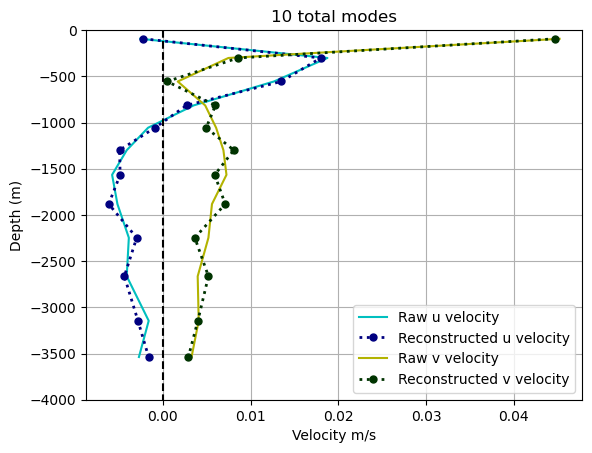

In [48]:
plt.style.use('default')
plt.plot(u_filtered,-eta_filtered,c='c')
plt.plot(np.nansum(Gz*amp_u,axis=1),-eta_filtered,'.:',c=[0., 0., 0.5],linewidth=2,markersize=10)

plt.plot(v_filtered,-eta_filtered,c=[0.7, 0.7, 0])
plt.plot(np.nansum(Gz*amp_v,axis=1),-eta_filtered,'.:',c=[0., 0.2, 0.],linewidth=2,markersize=10)

plt.grid()
plt.plot([0, 0],[0, -4000],'--',color=[0,0,0])

#plt.xlim(-.3, .3)
plt.ylim(-4000, 0);
plt.xlabel('Velocity m/s')
plt.legend(['Raw u velocity','Reconstructed u velocity','Raw v velocity','Reconstructed v velocity'])
plt.ylabel('Depth (m)')
plt.title('%i total modes' % (nmodes+1))
#plt.show()

([<matplotlib.axis.XTick at 0x2b515665f410>,
 <a list of 13 Text major ticklabel objects>)

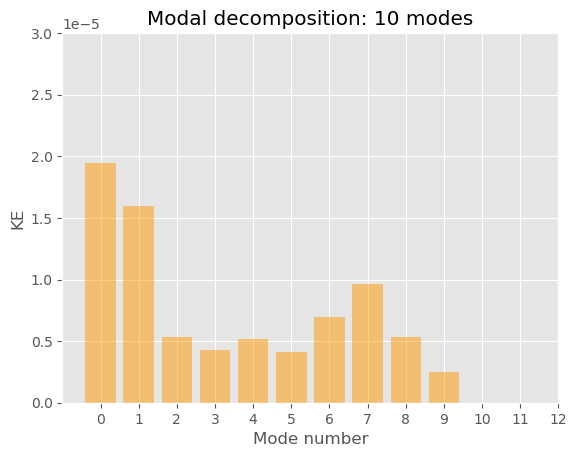

In [51]:
plt.style.use('ggplot')

x = np.linspace(0,nmodes,nmodes+1)
amp1 = amp_u[0,:]
amp2 = amp_v[0,:]

plt.bar(x, 0.5*amp1**2+0.5*amp2**2, color=[1., .6, 0.],alpha=0.5)
#plt.bar(x, 0.5*amp1**2, color=[1., .6, 0.],alpha=0.5)
#plt.bar(x, 0.5*amp2**2, color=[0., 0.2, 0.],alpha=0.5)
plt.xlabel("Mode number")
plt.ylabel("KE")
plt.title("Modal decomposition: %i modes" % (nmodes+1))
#plt.legend(['U','V'])
plt.ylim(0,3e-5)
plt.xlim(-1,10)
plt.xticks((0,1,2,3,4,5,6,7,8,9,10,11,12))

In [53]:
from scipy.io import loadmat
ds  = loadmat('Quarter_deg_QG_modes.mat') #Saved the KE associated with each mode based on the same analysis performed above.
lon = ds['lon']
lat = ds['lat']
KE  = ds['KE for each mode']
KE.shape
KE_vertical=np.nansum(KE,axis=0)
KE_vertical.shape

(560, 240)

0
1


Text(0.5, 1.0, '1/4$^\\circ$ KE fraction by mode')

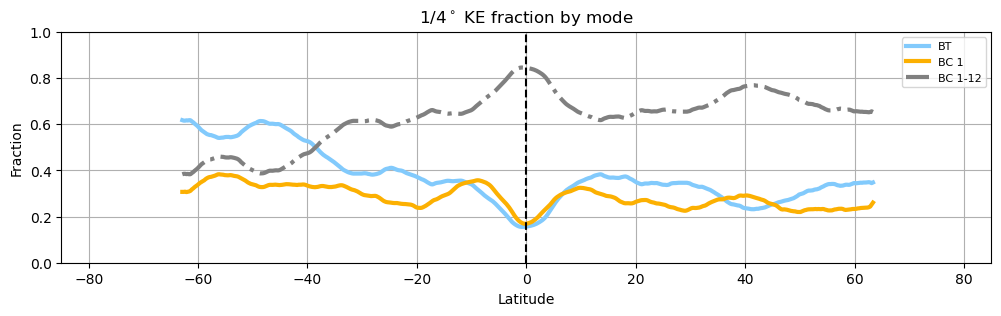

In [56]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.style.use('default')
plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
color=iter(['#82cafc','#fcb001','#fe2c54','#1fa774','#acfffc','#910951','#c875c4','#030aa7','#887191','#0a481e','#cb7723','#94568c','#fdff52'])
for i in range(2):
    print(i)
    c=next(color)
    KE_fraction=KE[i,:,:]/KE_vertical
    plt.plot(yh,np.convolve(np.nanmean(KE_fraction,axis=1), np.ones((window,))/window, mode='same'),'-',c=c,linewidth=3)
plt.grid()
BCsum=np.nansum(KE[1:,:,:],axis=0)/KE_vertical
plt.plot(yh,np.convolve(np.nanmean(BCsum,axis=1), np.ones((window,))/window, mode='same'),'-.',c=[0.5, 0.5, 0.5],linewidth=3)

plt.legend(['BT','BC 1','BC 1-12'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fraction by mode')